# Ambient Agents

## Context

[Ambient agents](https://blog.langchain.dev/ux-for-agents-part-2-ambient/) are long-running with different types of interaction patterns.

This agent will generate takes for Fantasy Football based upon a given league.

It is meant to be run at a regular interval e.g., daily.

It will look at current / recent events (from Reddit, in this case, but it can be extended for other sources).

It will generate takes for each Fantasy Manager if any of their players are mentioned in current events. 

Here, the initial interaction pattern is simply outward notification from agent to the fantasy manager in Slack.

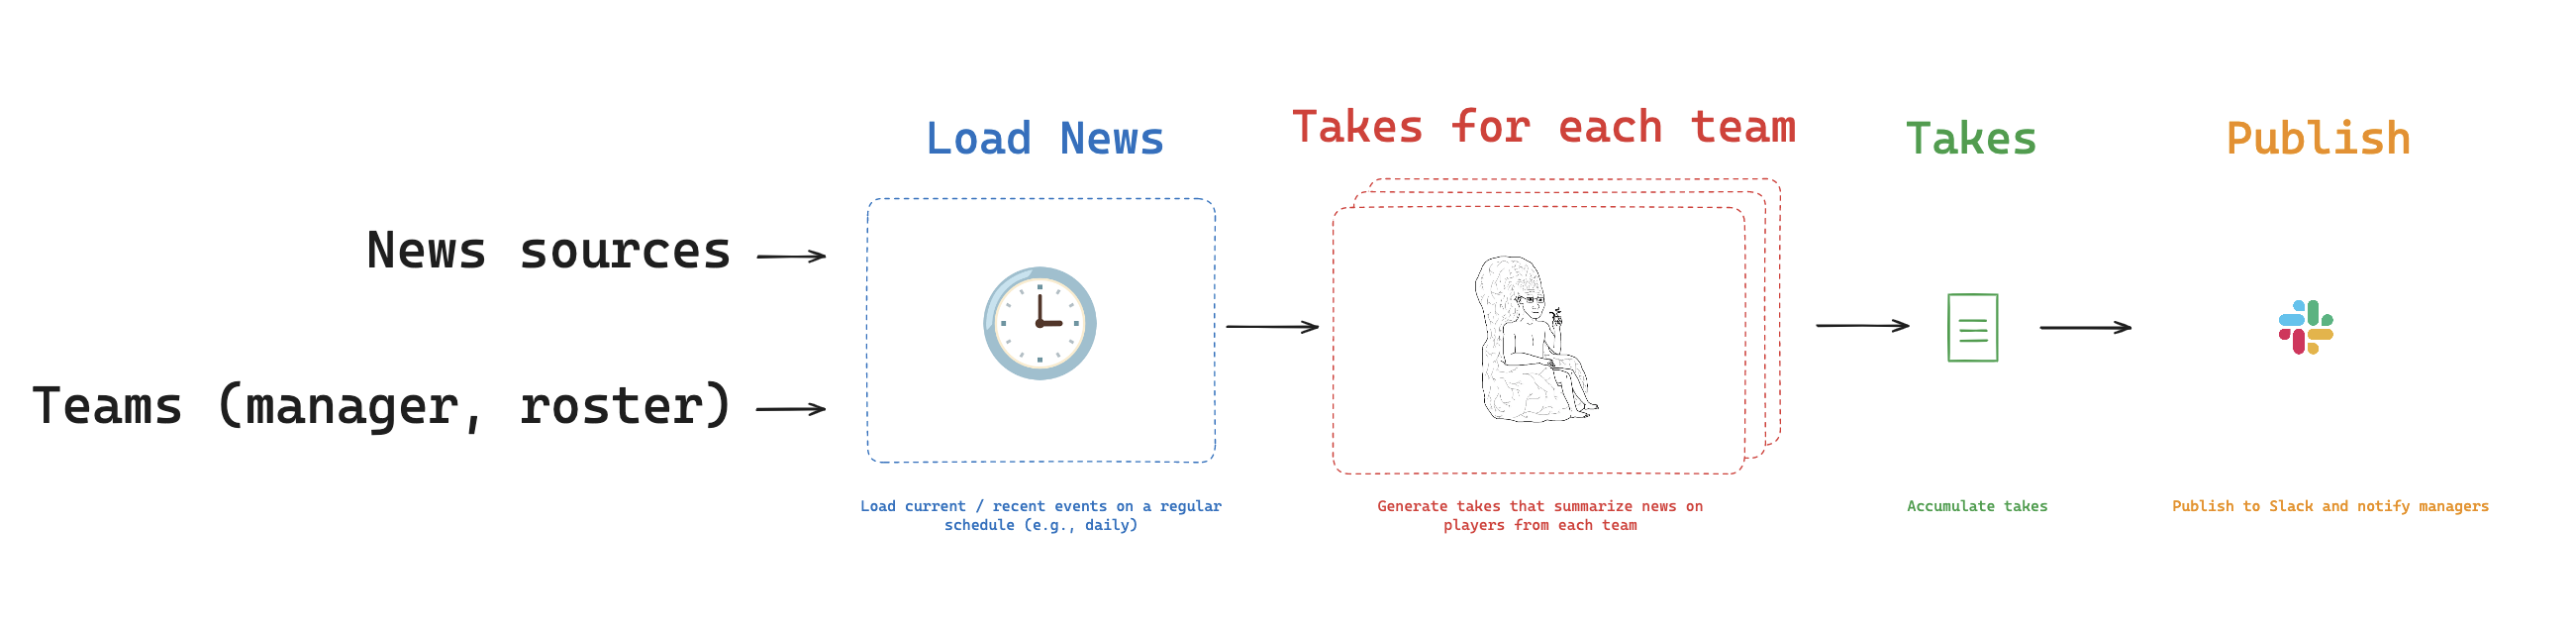

In [13]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai langchain-anthropic espn_api praw 

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [1]:
import os
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Data sources

### ESPN Fantasy

Follow README to set env vars.

In [2]:
import os
from espn_api.football import League

# Acess
ESPN_LEAGUE_ID = os.getenv('ESPN_LEAGUE_ID')
ESPN_S2 = os.getenv('ESPN_S2')
ESPN_SWID = os.getenv('ESPN_SWID')

# Hard code this once mapping from teams to Slack handles
teams = ['Milwaukee Bucks',
 'Hallucinations of Nick Saban',
 "Lance's Hit Squad",
 "Harrison's Team",
 'The Tank Bigsbies',
 'Taylor-Augmented Termination',
 'Rookie Season',
 'Mookillem',
 'This is the Wei',
 "Brace's Best Lineup"]

slack_handles = [
    "@Eric Han",
    "@Ben Mangum",
    "@lance",
    "@Harrison Chase",
    "@Sam Noyes",
    "@Jacob Lee",
    "@Maddy",
    "@Mukil Loganathan",
    "@Wei Wong",
    "@Brace Sproul",
]

TEAM_TO_SLACK = {team: handle for team, handle in zip(teams, slack_handles)}

### Reddit

Follow README to set env vars.

In [3]:
import praw

# Reddit creds
reddit_client_id = os.getenv('REDDIT_CLIENT_ID')
reddit_client_secret = os.getenv('REDDIT_CLIENT_SECRET')

# Initialize the Reddit instance
reddit = praw.Reddit(client_id=reddit_client_id,
                     client_secret=reddit_client_secret,
                     user_agent='Fantasy Football Loader')

def get_recent_reddit_posts(subreddit_name,
                            filter_to_use,
                            number_of_posts,
                            number_of_comments,
                           ):

    """
    Retrieve top posts and their comments from a specified subreddit.

    Args:
    subreddit_name (str): Name of the subreddit to fetch posts from.
    filter_to_use (str): Time filter for top posts (e.g., 'day', 'week', 'month', 'year', 'all').
    number_of_posts (int): Number of top posts to retrieve.
    number_of_comments (int): Number of top comments to fetch for each post.

    Returns:
    str: A formatted string containing information about the top posts and their comments.
         Each post entry includes:
         - Post title
         - Post URL
         - Post score
         - Top comments (up to the specified number) with their scores
         Posts are separated by a line of '=' characters.

    Note:
    This function requires a properly initialized 'reddit' object with necessary permissions.
    """

    # Access the subreddit
    subreddit = reddit.subreddit(subreddit_name)
    
    # Get top posts based on the specified filter
    top_posts = subreddit.top(time_filter=filter_to_use, limit=number_of_posts)
    
    # Initialize an empty string to store the output
    reddit_expert_context = ""
    
    # Process each post
    for post in top_posts:
        reddit_expert_context += f"Title: {post.title}\n"
        reddit_expert_context += f"Source Data URL: {post.url}\n"
        reddit_expert_context += f"Reddit Post URL: {post.shortlink}\n"
        reddit_expert_context += f"Score: {post.score}\n"
        
        post.comments.replace_more(limit=0)  # Flatten the comment tree
        
        # Get the specified number of top comments
        for i, comment in enumerate(post.comments[:number_of_comments]):
            reddit_expert_context += f"Top Comment {i+1}: {comment.body}\n"
            reddit_expert_context += f"Comment Score: {comment.score}\n\n"
        
        reddit_expert_context += "="*50 + "\n\n"

    return reddit_expert_context

## Build graph

### Parameters and LLM

We created Slack webhook to a channel for notification

In [5]:
import os
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic 

llm = ChatOpenAI(model="gpt-4o", temperature=0) 
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0) 
take_bot_url = os.getenv('TAKE_BOT_SLACK_URL')

### State

State for the graph

In [6]:
import operator
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, List, Annotated

class Take(BaseModel):
    title: str = Field(
        description="Punchy summary title for the take",
    )
    take: str = Field(
        description="Fun, punchy observation about a specific player",
    )
    source_url: str = Field(
        description="Source data URL for information in the take (if applicable)",
    )
    reddit_url: str = Field(
        description="Reddit post URL for the post",
    )
    reasoning: str = Field(
        description="Provide your reasoning for the take, which confirms that the specific player is on the roster of the Fantasy Manager",
    )

class Takes(BaseModel):
    takes: List[Take] = Field(
        description="A list of takes, each containing a title and a take observation."
    )

class TakeGeneratorOutputState(TypedDict):
    takes: List[Take]

class TakeGeneratorState(TypedDict):
    team: dict
    context: str
    takes: List[Take]

class OverallState(TypedDict):
    league: List[dict]
    context: str
    takes: Annotated[List[Take], operator.add]

### Graph

We generate takes per team and `write_to_slack` as [blocks](https://app.slack.com/block-kit-builder/T04F8K3FZB5#%7B%22blocks%22:%5B%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22Hello,%20Assistant%20to%20the%20Regional%20Manager%20Dwight!%20*Michael%20Scott*%20wants%20to%20know%20where%20you'd%20like%20to%20take%20the%20Paper%20Company%20investors%20to%20dinner%20tonight.%5Cn%5Cn%20*Please%20select%20a%20restaurant:*%22%7D%7D,%7B%22type%22:%22divider%22%7D,%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22*Farmhouse%20Thai%20Cuisine*%5Cn:star::star::star::star:%201528%20reviews%5Cn%20They%20do%20have%20some%20vegan%20options,%20like%20the%20roti%20and%20curry,%20plus%20they%20have%20a%20ton%20of%20salad%20stuff%20and%20noodles%20can%20be%20ordered%20without%20meat!!%20They%20have%20something%20for%20everyone%20here%22%7D,%22accessory%22:%7B%22type%22:%22image%22,%22image_url%22:%22https://s3-media3.fl.yelpcdn.com/bphoto/c7ed05m9lC2EmA3Aruue7A/o.jpg%22,%22alt_text%22:%22alt%20text%20for%20image%22%7D%7D,%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22*Kin%20Khao*%5Cn:star::star::star::star:%201638%20reviews%5Cn%20The%20sticky%20rice%20also%20goes%20wonderfully%20with%20the%20caramelized%20pork%20belly,%20which%20is%20absolutely%20melt-in-your-mouth%20and%20so%20soft.%22%7D,%22accessory%22:%7B%22type%22:%22image%22,%22image_url%22:%22https://s3-media2.fl.yelpcdn.com/bphoto/korel-1YjNtFtJlMTaC26A/o.jpg%22,%22alt_text%22:%22alt%20text%20for%20image%22%7D%7D,%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22*Ler%20Ros*%5Cn:star::star::star::star:%202082%20reviews%5Cn%20I%20would%20really%20recommend%20the%20%20Yum%20Koh%20Moo%20Yang%20-%20Spicy%20lime%20dressing%20and%20roasted%20quick%20marinated%20pork%20shoulder,%20basil%20leaves,%20chili%20&%20rice%20powder.%22%7D,%22accessory%22:%7B%22type%22:%22image%22,%22image_url%22:%22https://s3-media2.fl.yelpcdn.com/bphoto/DawwNigKJ2ckPeDeDM7jAg/o.jpg%22,%22alt_text%22:%22alt%20text%20for%20image%22%7D%7D,%7B%22type%22:%22divider%22%7D,%7B%22type%22:%22actions%22,%22elements%22:%5B%7B%22type%22:%22button%22,%22text%22:%7B%22type%22:%22plain_text%22,%22text%22:%22Farmhouse%22,%22emoji%22:true%7D,%22value%22:%22click_me_123%22%7D,%7B%22type%22:%22button%22,%22text%22:%7B%22type%22:%22plain_text%22,%22text%22:%22Kin%20Khao%22,%22emoji%22:true%7D,%22value%22:%22click_me_123%22,%22url%22:%22https://google.com%22%7D,%7B%22type%22:%22button%22,%22text%22:%7B%22type%22:%22plain_text%22,%22text%22:%22Ler%20Ros%22,%22emoji%22:true%7D,%22value%22:%22click_me_123%22,%22url%22:%22https://google.com%22%7D%5D%7D%5D%7D). 

We'll add a breakpoint before it to ensure that we want to write! 

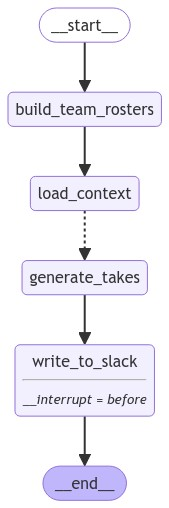

In [7]:
import requests

from langchain_core.messages import SystemMessage, HumanMessage

from langgraph.constants import Send
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START

from IPython.display import Image, display

def build_team_rosters(state: OverallState):
    """
    Build a list of team rosters with associated Slack handles.

    Args:
    teams (list): A list of Team objects from the ESPN API.
    team_to_slack (dict): A dictionary mapping team names to Slack handles.

    Returns:
    list: A list of dictionaries, each containing a team's Slack handle and list of players.
    Each dictionary has the format:
    {
        "slack_handle": str,
        "players": list[str]
    }
    """
    # Get league data
    league = League(league_id=ESPN_LEAGUE_ID, 
                    year=2024, 
                    espn_s2=ESPN_S2, 
                    swid=ESPN_SWID)

    # Slack handle -> roster mapping
    teams = league.teams

    roster_list = []
    
    for team in teams:
        team_name = team.team_name
        slack_handle = TEAM_TO_SLACK.get(team_name, "Unknown")
        
        players = [player.name for player in team.roster]
        
        roster_dict = {
            "slack_handle": slack_handle,
            "players": players
        }
        
        roster_list.append(roster_dict)
    
    return {"league": roster_list}

def load_context(state: OverallState):
    """ Generate context from Reddit """
    
    # Replace with the subreddit you're interested in
    subreddit_name = 'fantasyfootball'
    
    # Get top comments from past <day, month, etc>
    filter_to_use = 'day'
    
    # Number of posts to gather
    number_of_posts = 10
    
    # Number of top comments to gather per post
    number_of_comments = 5

    # Pull recent posts 
    reddit_recent_posts = get_recent_reddit_posts(subreddit_name,
                                                  filter_to_use,
                                                  number_of_posts,
                                                  number_of_comments)

    return {"context": reddit_recent_posts}

take_instructions="""Your job is to generate fun, punchy takes for a Fantasy Football manager about the players on his / her team.

Carefully review and memorize the list of players on the manager's team provided by the manager at the end of these instructions. 

This list of players is definitive and should be used as the sole reference for the manager's team composition.

Examine the recent news and events in the world of the NFL provided below.

For each news item, systematically cross-reference it against the memorized list of the manager's players. 

IMPORTANT: Only generate takes for players who are EXPLICITLY and DIRECTLY mentioned by name in the news items. Do not infer, extrapolate, or generate takes based on indirect implications or general trends that might affect a player.

If and only if a news item specifically mentions a player by name, and that player is on the manager's team, generate a take about that player.

Each take should be player-specific and based solely on the provided news. Do not include speculation or information from outside the given news items.

Create a numbered list of takes and format each take as follows:

Include a concise and fun subject line
Start with "Hey {manager}:" and then provide a brief summary of the news, focusing only on what is directly stated about the player
Include the exact Source URL of the news item, if provided
Include the exact Reddit post URL of the news item
Provide your reasoning for the take, which confirms that the specific player is on the roster of the Fantasy Manager

After generating each take, double-check that the player mentioned is indeed on the manager's team by referring back to the original list.

If no news items directly mention any players on the manager's team by name, explicitly state that no relevant news was found for the team's players.

Before finalizing your response, review all generated takes and confirm once more that each mentioned player is on the manager's team as listed at the beginning of the prompt and is explicitly named in the news item.

If a player is not directly named in the news or you're unsure about whether a player is on the team, do not generate a take for that player.

Here are the recent news and events in the world of the NFL to base your takes on: {context}"""

take_format_instructions="""Your job is to review and then format a final list of fun, punchy takes for a Fantasy Football manager about the players on his / her team.

Review Phase:
1. First, check if any takes are provided in the list of takes. If the list of takesis empty or contains no takes, provide no output and end the process.

2. If there are takes provided, then carefully review and memorize the list of players on the manager's team provided at the end of these instructions. This list is definitive and should be used as the sole reference for the manager's team composition.

3. For each take in the list of takes, verify that:
   a) The player mentioned is EXPLICITLY and DIRECTLY named in the take.
   b) The player is on the manager's team (as per the provided list).
   c) The take is based solely on the information provided within the list of takes.

4. Discard any takes that do not meet ALL of the above criteria.

Here is the list of takes to review:

{context}

---

Formatting Phase:
If any takes remain after the review phase, format each take as follows:

1. Include a concise and fun subject line
2. Start the summary with "Hey {manager}:" and then provide a brief summary of the news, focusing only on what is directly stated about the player
3. Include the exact Source URL of the news item, if provided
4. Include the exact Reddit post URL of the news item
5. End with your reasoning for the take, which confirms that the specific player is on the roster of the Fantasy Manager

Final Check:

Before finalizing your response, review ALL formatted takes once more to ensure they meet all criteria.

Ensure that the summary of EACH formatted take starts with "Hey {manager}:".

If no takes remain after the review process, provide no output."""

def generate_takes(state: TakeGeneratorState) -> TakeGeneratorOutputState:
    """ Node to generate takes, and review / format them """

    # Get team
    team = state["team"]
    context = state["context"]

    # Get player and manager
    manager = team['slack_handle']
    players = ' // '.join(player for player in team['players'])

    # Instructions
    take_system_promot = take_instructions.format(manager=manager, context=context)
    take_human_message = "Only generate takes if any of these players are EXPLICITLY and DIRECTLY in the news. Here are the players: {players}".format(players=players)
    
    # Generate takes
    takes = llm.invoke([SystemMessage(content=take_system_promot)]+[HumanMessage(content=take_human_message)])

    # Enforce structured output
    structured_llm = llm.with_structured_output(Takes)
    take_formatting_system_promot = take_format_instructions.format(manager=manager, context=takes.content)
    take_formatting_human_message = "Only generate your final, formatted takes if any of these players are EXPLICITLY and DIRECTLY in the provided list of takes. Here are the players: {players}".format(players=players)
 
    # Generate takes
    formatted_takes = structured_llm.invoke([SystemMessage(content=take_formatting_system_promot)]+[HumanMessage(content=take_formatting_human_message)])
    
    # Write to state  
    return {"takes": [formatted_takes]}

def initiate_all_takes(state: OverallState):
    """ This is the "map" step to initiate takes per team """    

    league = state["league"]
    context = state["context"]
    return [Send("generate_takes", {"team": team,
                                    "context": context}) for team in league]

def write_to_slack(state: OverallState):
    """ Write takes to Slack """
    
    # Full set of interview reports
    takes = state["takes"]

    # Write to your Slack Channel via webhook
    true = True
    headers = {
        'Content-Type': 'application/json',
    }

    # Write to slack
    for t in takes:
        for take in t.takes:
            
            # Blocks
            blocks = []
            
            # Block 1: Title section
            blocks.append({
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"*{take.title}*"
                }
            })
            
            # Block 2: Divider
            blocks.append({
                "type": "divider"
            })
            
            # Block 3: Content section
            blocks.append({
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"{take.take}"
                }
            })

            # Block 4: Divider
            blocks.append({
                "type": "divider"
            })

            # Block 5: Source URL
            blocks.append({
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"Reddit post link: {take.reddit_url}"
                }
            })

            # Block 6: Divider
            blocks.append({
                "type": "divider"
            })

            # Block 7: Reddit URL
            blocks.append({
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"Original source (if provided): {take.source_url}"
                }
            })
            
            blocks.insert(0, {
                "type": "header",
                "text": {
                    "type": "plain_text",
                    "text": ":fire: :robot_face: Take-Bot is heating up ...",
                    "emoji": true
                }
            })
            
            data = {
                "blocks": blocks,
            }
            
            response = requests.post(take_bot_url, headers=headers, json=data)

# Add nodes and edges 
overall_builder = StateGraph(OverallState)

# Add nodes and edges 
overall_builder.add_node("build_team_rosters", build_team_rosters)
overall_builder.add_node("load_context", load_context)
overall_builder.add_node("generate_takes", generate_takes)
overall_builder.add_node("write_to_slack",write_to_slack)

# Flow
overall_builder.add_edge(START, "build_team_rosters")
overall_builder.add_edge("build_team_rosters", "load_context")
overall_builder.add_conditional_edges("load_context", initiate_all_takes, ["generate_takes"])
overall_builder.add_edge("generate_takes", "write_to_slack")
overall_builder.add_edge("write_to_slack", END)

# Compile
memory = MemorySaver()
graph = overall_builder.compile(interrupt_before=['write_to_slack'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [8]:
thread = {"configurable": {"thread_id": "1"}}
result = graph.invoke({"league": []}, thread)

In [16]:
from IPython.display import Markdown, display
state = graph.get_state(thread)
for takes in state.values['takes']:
    for take in takes.takes:
               display(Markdown(f"""
### {take.title}

{take.take}

**Source URL:** {take.source_url}

**Reddit URL:** {take.reddit_url}

**Reasoning:**

{take.reasoning}

---
"""))


### CMC's Calf Conundrum

Hey @Eric Han: Christian McCaffrey is listed with a calf/Achilles injury and will be limited in practice. Kyle Shanahan clarified it's not a new injury, but part of the calf issue from training camp.

**Source URL:** https://twitter.com/mattbarrows/status/1831783117709045813

**Reddit URL:** https://redd.it/1f9vrz9

**Reasoning:**

This take is directly relevant to your team as Christian McCaffrey is explicitly listed on your roster. The news about his calf/Achilles injury and limited practice is important information for fantasy managers to monitor, especially heading into Week 1.

---



### Rachaad's Reign in Question?

Hey @Ben Mangum: Bucs HC Todd Bowles commented on the RB rotation, stating that while Rachaad White will start, they'll "go from there and see how the other guys are used." He mentioned it'll be on a "game-by-game basis" and they'll "normally go with the hot hand."

**Source URL:** https://x.com/CoachspeakIndex/status/1831470039276646414?t=QoqRHYpzE5k553PzO8Yndw&s=19

**Reddit URL:** https://redd.it/1f985pv

**Reasoning:**

This take is included because Rachaad White is explicitly mentioned and is on the list of players provided for the Fantasy Manager's team. The information directly impacts White's potential usage and fantasy value, which is relevant for the manager's decision-making.

---



### Gus Bus Rolling into the End Zone?

Hey @lance: The Gus Bus might be fueled by touchdowns this season! In a discussion about Week 1 Vegas props for uncertain backfields, a commenter enthusiastically exclaimed, "THE GUS BUS RUNS ON TDS!!"

**Source URL:** https://redd.it/1f98xk4

**Reddit URL:** https://redd.it/1f98xk4

**Reasoning:**

This take is relevant because Gus Edwards is explicitly mentioned in the take and is on your roster. The information comes directly from the provided list of takes, specifically from a comment in a discussion about Week 1 Vegas props.

---



### The Breece Beast is Back!

Hey @Harrison Chase: A Reddit user mentioned drafting Breece Hall at the 6th pick, saying "Breece fell to me at 6, and I knew nothing else mattered." This comment suggests high expectations for Breece Hall this season. As he's on your roster, you might be in for a treat if he lives up to the hype!

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1f9ff7x

**Reasoning:**

Breece Hall is explicitly mentioned in the take and is on the provided list of players on the Fantasy Manager's team.

---



### Tight End Teaser

Hey @Harrison Chase: Kyle Pitts tweeted, "Damn 2 less plays in a rack got y'all concerned 💀 I'll see you all Sunday🤞🏽" in response to concerns about his usage. As a Pitts owner, this tweet should reassure you about his involvement in the Falcons' offense. He seems confident and ready to prove himself on Sunday!

**Source URL:** https://x.com/kylepitts__/status/1831482488172245187

**Reddit URL:** https://redd.it/1f99in8

**Reasoning:**

Kyle Pitts is explicitly mentioned in the take and is on the provided list of players on the Fantasy Manager's team.

---



### Chicago's New Aerial Threat

Hey @Harrison Chase: In a comment about stacking, someone joked, "Jokes on you when D'Andre Swift throws a TD to DJ Moore." While this is clearly a joke, it highlights the excitement around DJ Moore in Chicago. As he's on your team, keep an eye on his connection with Justin Fields this season!

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1f9dkyv

**Reasoning:**

DJ Moore is explicitly mentioned in the take and is on the provided list of players on the Fantasy Manager's team.

---



### Jets Taking Off?

Hey @Harrison Chase: Aaron Rodgers was mentioned in a comment about stacking, saying "What about when Keenan Allen threw a TD to Mike Williams?" While this comment doesn't directly relate to Rodgers' performance, it reminds us of the potential for creative plays in the NFL. As Rodgers is on your team, you'll want to watch how he utilizes his new weapons in the Jets' offense.

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1f9dkyv

**Reasoning:**

Aaron Rodgers is explicitly mentioned in the take and is on the provided list of players on the Fantasy Manager's team.

---



### Jamo's Aiming for the Stars!

Hey @Sam Noyes: Jameson Williams told ESPN he wants to have the most receiving yards and touchdowns in the entire NFL this season. He's not concerned about catch totals, saying, "I know what I'm gonna do when I get the ball."

**Source URL:** https://x.com/E_Woodyard/status/1829720055627567147

**Reddit URL:** https://redd.it/1f9ctyr

**Reasoning:**

Jameson Williams is explicitly listed on your team roster, and this news item directly quotes him discussing his goals for the upcoming season. This ambitious statement shows his confidence and potential for big plays, which could be exciting for fantasy managers. However, it's important to note that he'll need to significantly increase his production from previous seasons to achieve these lofty targets. Keep an eye on his target share and big-play potential in the Lions' offense.

---



### Hock's Comeback Countdown

Hey @Jacob Lee: The Vikings are 'loosely targeting' Week 7 for T.J. Hockenson's return from injury.

**Source URL:** https://x.com/rotoworld_fb/status/1831684980273246508?s=46&t=Z6rzQMsCcNjQTCFePgG2FA

**Reddit URL:** https://redd.it/1f9mu38

**Reasoning:**

This take is directly relevant to your roster as T.J. Hockenson is explicitly listed among your players. The news provides important information about his expected return timeline, which will impact your lineup decisions for the first six weeks of the season. It's crucial for you to plan alternative tight end options and consider utilizing your IR slot if available in your league.

---



### Aaron Jones Confidence Boost

Hey @Maddy: Aaron Jones confidently stated, "Make sure you got me in your leagues," suggesting he's ready for a strong performance.

**Source URL:** https://x.com/AhmadHicksTV/status/1831459559480914220

**Reddit URL:** https://redd.it/1f9pkwd

**Reasoning:**

This take is relevant because Aaron Jones is explicitly mentioned in the news item and is on your roster. His confident statement implies he's expecting to have a good fantasy performance, which could be promising for your team.

---



### Ty Chandler: A Sleeper Pick?

Hey @Mukil Loganathan: A top comment on a post about Aaron Jones suggests, "Make sure you pick up Ty Chandler right now if he's available."

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1f9pkwd

**Reasoning:**

This take is relevant because Ty Chandler is explicitly mentioned in the provided list of takes and is also on your roster. The take directly quotes a comment about Chandler, suggesting potential value in fantasy leagues.

---



### 49ers D/ST: Potential Ripple Effect

Hey @Wei Wong: Christian McCaffrey (calf/Achilles) will be limited in today's practice for the 49ers. Kyle Shanahan clarified that this isn't a new injury, but part of the calf issue McCaffrey sustained in training camp.

**Source URL:** https://twitter.com/mattbarrows/status/1831783117709045813

**Reddit URL:** https://redd.it/1f9vrz9

**Reasoning:**

While this news primarily focuses on Christian McCaffrey, it's relevant to your team because you have the 49ers D/ST on your roster. The status of a key offensive player like McCaffrey could indirectly impact the defense's performance by affecting field position and time of possession. This connection makes the take pertinent to your fantasy team.

---



### Singletary's Snaps Soaring

Hey @Brace Sproul: Giants beat reporter Jordan Raanan suggests RB Devin Singletary could see over 80% of the team's snaps in a role similar to Saquon Barkley last season.

**Source URL:** https://x.com/jordanraanan/status/1831690302282674266?s=46&t=Z6rzQMsCcNjQTCFePgG2FA

**Reddit URL:** https://redd.it/1f9oacn

**Reasoning:**

This take is relevant because Devin Singletary is explicitly mentioned and is on the list of players provided for the Fantasy Manager's team. The information comes directly from the given list of takes and focuses on Singletary's potential increased role with the Giants.

---


Now, let's confirm the next node to call.

In [17]:
print(state.next)

('write_to_slack',)


Now, let's write to Slack.

In [ ]:
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

We can look at the trace:

https://smith.langchain.com/public/20aaf460-2c69-4aea-b3a6-8fb7a1b07986/r